# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


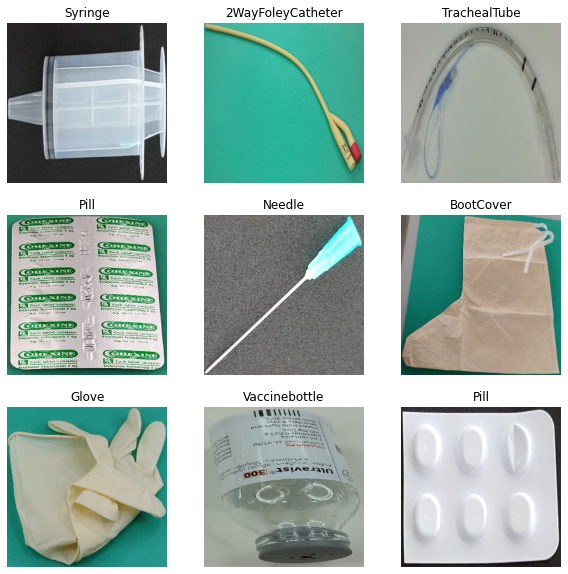

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
EPOCHS = 1000
save_model_interval = 10
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch{epoch:03d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/1000
49/49 [==============================] - 70s 730ms/step - loss: 1.1633 - accuracy: 0.6805 - val_loss: 5.3777 - val_accuracy: 0.0142
Epoch 2/1000
49/49 [==============================] - 27s 546ms/step - loss: 0.4031 - accuracy: 0.8805 - val_loss: 5.2347 - val_accuracy: 0.0699
Epoch 3/1000
49/49 [==============================] - 27s 548ms/step - loss: 0.2291 - accuracy: 0.9334 - val_loss: 4.5402 - val_accuracy: 0.2277
Epoch 4/1000
49/49 [==============================] - 27s 548ms/step - loss: 0.1501 - accuracy: 0.9551 - val_loss: 1.6355 - val_accuracy: 0.5834
Epoch 5/1000
49/49 [==============================] - 27s 549ms/step - loss: 0.1925 - accuracy: 0.9457 - val_loss: 4.1095 - val_accuracy: 0.3571
Epoch 6/1000
49/49 [==============================] - 27s 549ms/step - loss: 0.1546 - accuracy: 0.9538 - val_loss: 3.2412 - val_accuracy: 0.4541
Epoch 7/1000
49/49 [==============================] - 27s 550ms/step - loss: 0.0950 - accuracy: 0.9706 - val_loss: 2.3449 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

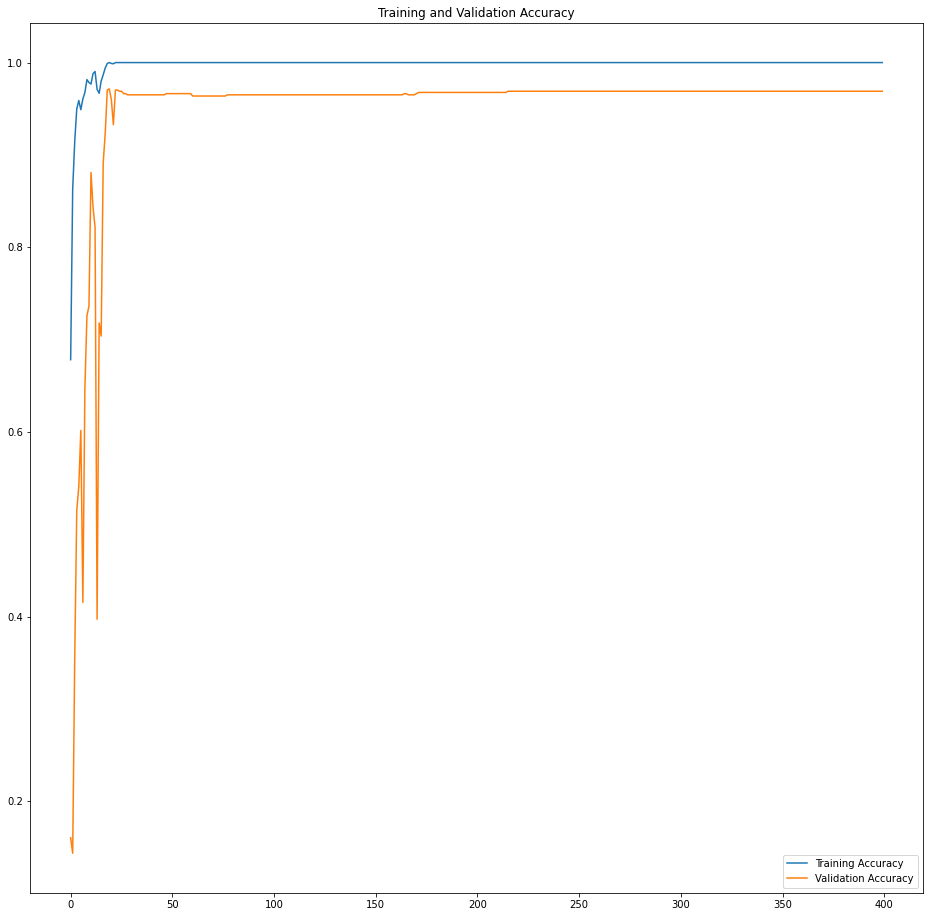

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


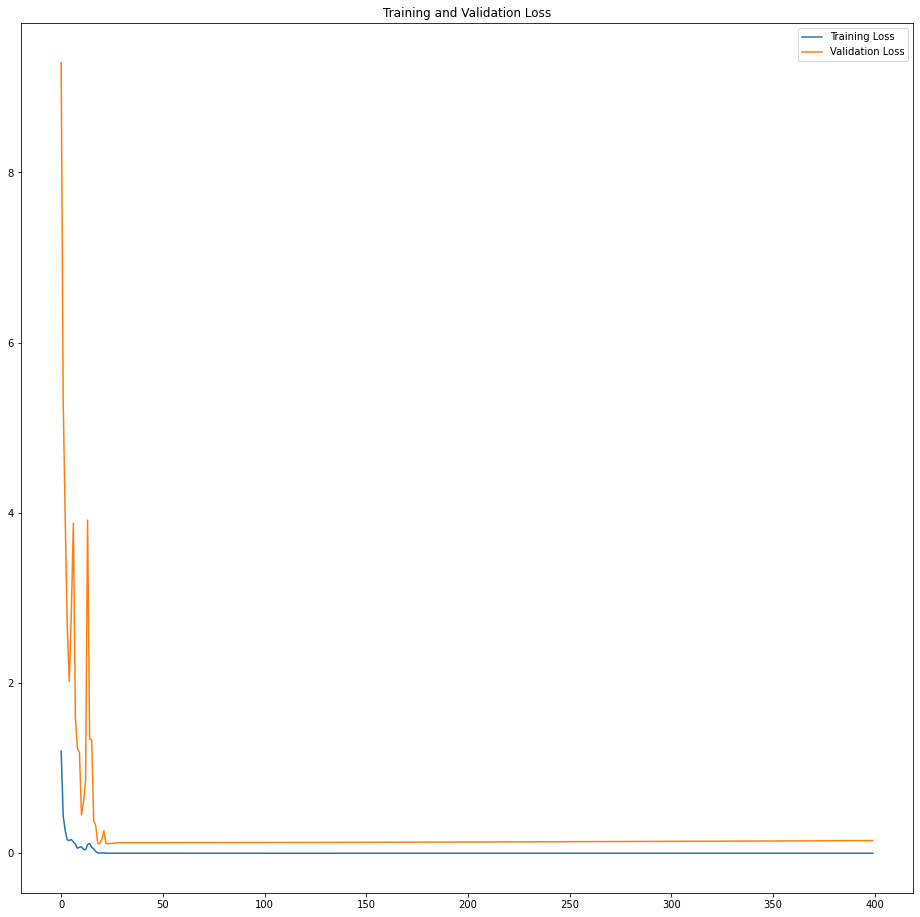

In [ ]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 15s 385ms/step - loss: 4.4394 - accuracy: 0.5518
test_indoor_ds_results:test loss, test acc: [4.439370155334473, 0.5518394708633423]


In [ ]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 458ms/step - loss: 2.6888 - accuracy: 0.6404
test_outdoor_ds_results:test loss, test acc: [2.6888465881347656, 0.64044588804245]


In [ ]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 207ms/step - loss: 1.4458 - accuracy: 0.7679
test_belt_ds_results:test loss, test acc: [1.4457722902297974, 0.7679057121276855]


In [ ]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch005-val_acc0.54.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch010-val_acc0.74.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch015-val_acc0.72.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch020-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch025-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch030-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch035-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch045-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassImbalanced/OurTOP01-epoch050-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurTOP01-NoClassI

In [ ]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 150ms/step - loss: 2.8587 - accuracy: 0.3840
Epoch005 
 test_indoor_acc=0.16610924899578094 
 test_outdoor_acc=0.2837579548358917 
 test_belt_acc=0.3839528560638428
35/35 [==============================] - 5s 152ms/step - loss: 3.1126 - accuracy: 0.4497
Epoch010 
 test_indoor_acc=0.43366777896881104 
 test_outdoor_acc=0.314012736082077 
 test_belt_acc=0.44968268275260925
35/35 [==============================] - 5s 147ms/step - loss: 3.7139 - accuracy: 0.4365
Epoch015 
 test_indoor_acc=0.35618728399276733 
 test_outdoor_acc=0.41369426250457764 
 test_belt_acc=0.4365367293357849
35/35 [==============================] - 5s 146ms/step - loss: 1.2125 - accuracy: 0.7579
Epoch020 
 test_indoor_acc=0.5078037977218628 
 test_outdoor_acc=0.6022292971611023 
 test_belt_acc=0.7579329013824463
35/35 [==============================] - 5s 145ms/step - loss: 1.1942 - accuracy: 0.7471
Epoch025 
 test_indoor_acc=0.458751380443573 
 test_outdoor_acc=0.639490425

range(5, 405, 5)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

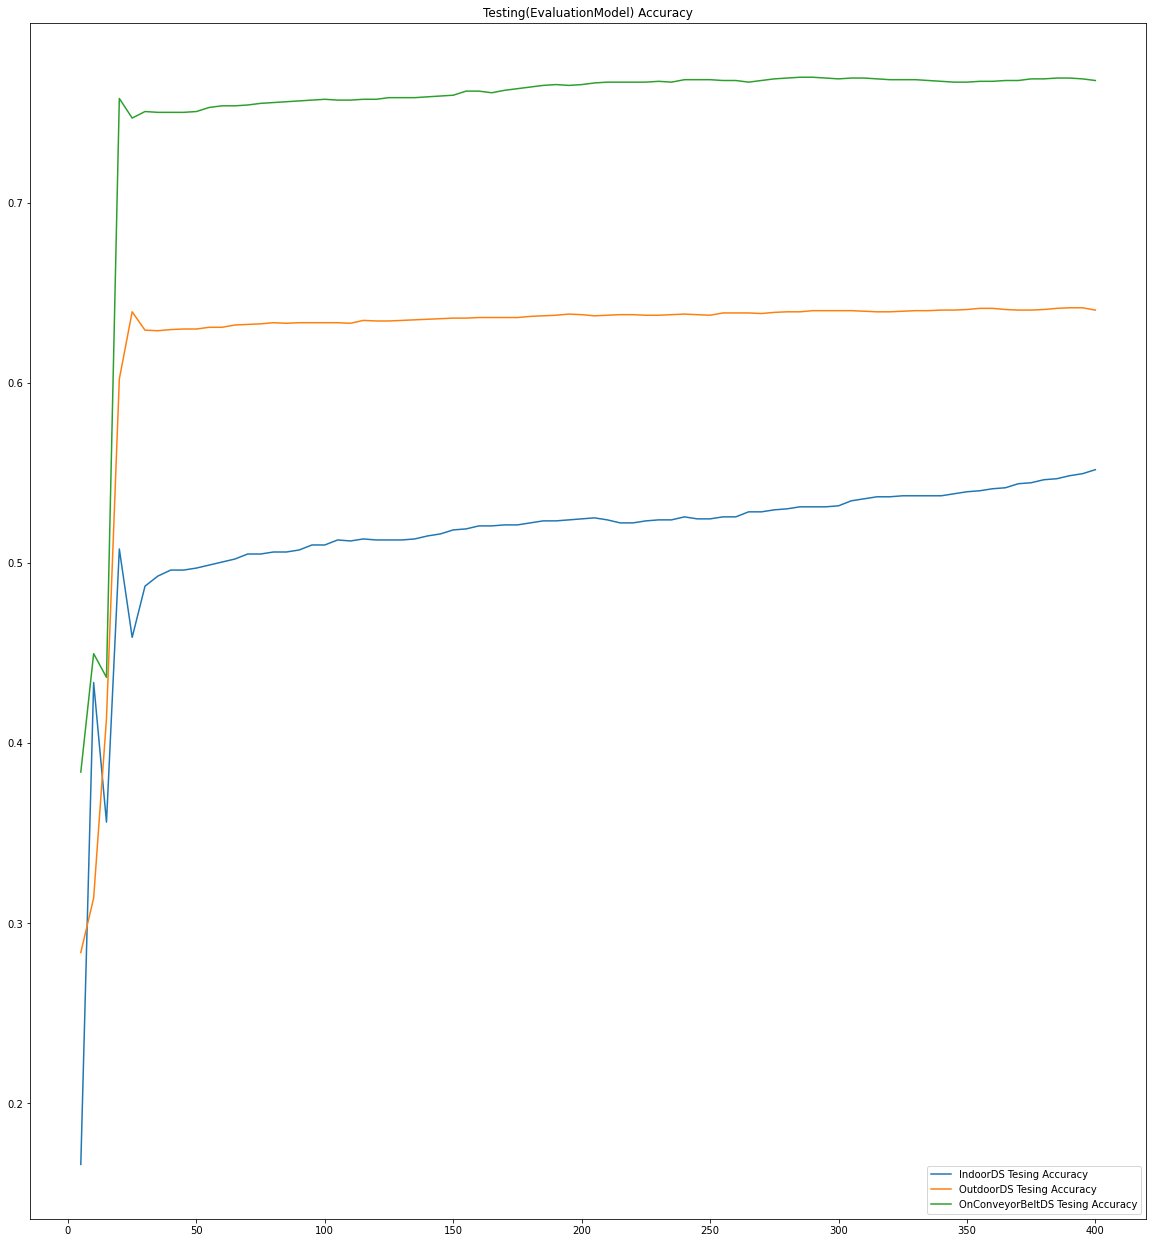

In [ ]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

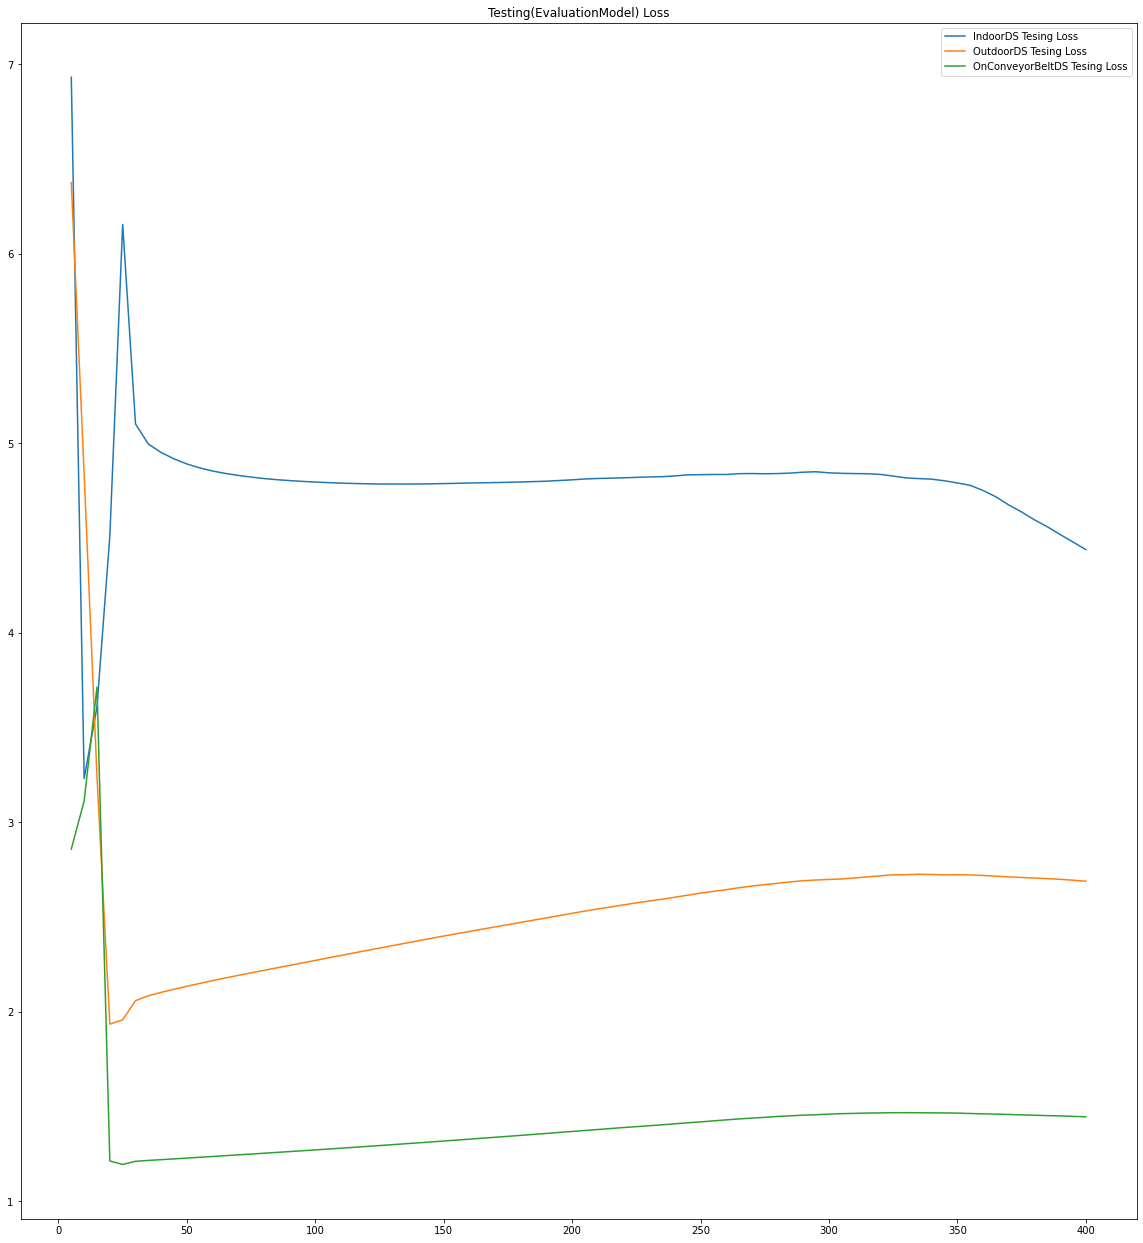

In [ ]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [ ]:
test_indoor_acc

[0.16610924899578094,
 0.43366777896881104,
 0.35618728399276733,
 0.5078037977218628,
 0.458751380443573,
 0.4871794879436493,
 0.49275362491607666,
 0.4960981011390686,
 0.4960981011390686,
 0.4972129464149475,
 0.4988851845264435,
 0.5005574226379395,
 0.502229630947113,
 0.5050167441368103,
 0.5050167441368103,
 0.5061315298080444,
 0.5061315298080444,
 0.5072463750839233,
 0.5100334286689758,
 0.5100334286689758,
 0.5128205418586731,
 0.5122631192207336,
 0.5133779048919678,
 0.5128205418586731,
 0.5128205418586731,
 0.5128205418586731,
 0.5133779048919678,
 0.5150501728057861,
 0.516165018081665,
 0.5183946490287781,
 0.5189520716667175,
 0.5206242799758911,
 0.5206242799758911,
 0.5211817026138306,
 0.5211817026138306,
 0.5222965478897095,
 0.5234113931655884,
 0.5234113931655884,
 0.5239687561988831,
 0.5245261788368225,
 0.525083601474762,
 0.5239687561988831,
 0.5222965478897095,
 0.5222965478897095,
 0.5234113931655884,
 0.5239687561988831,
 0.5239687561988831,
 0.5256410241

In [ ]:
test_outdoor_acc

[0.2837579548358917,
 0.314012736082077,
 0.41369426250457764,
 0.6022292971611023,
 0.6394904255867004,
 0.6292993426322937,
 0.6289808750152588,
 0.6296178102493286,
 0.6299362778663635,
 0.6299362778663635,
 0.630891740322113,
 0.630891740322113,
 0.6321656107902527,
 0.6324840784072876,
 0.6328025460243225,
 0.6334394812583923,
 0.6331210136413574,
 0.6334394812583923,
 0.6334394812583923,
 0.6334394812583923,
 0.6334394812583923,
 0.6331210136413574,
 0.634713351726532,
 0.6343948841094971,
 0.6343948841094971,
 0.634713351726532,
 0.6350318193435669,
 0.6353503465652466,
 0.6356688141822815,
 0.6359872817993164,
 0.6359872817993164,
 0.6363057494163513,
 0.6363057494163513,
 0.6363057494163513,
 0.6363057494163513,
 0.6369426846504211,
 0.637261152267456,
 0.637579619884491,
 0.6382165551185608,
 0.6378980875015259,
 0.637261152267456,
 0.637579619884491,
 0.6378980875015259,
 0.6378980875015259,
 0.637579619884491,
 0.637579619884491,
 0.6378980875015259,
 0.6382165551185608,
 0

In [ ]:
test_belt_acc

[0.05938350036740303,
 0.17497733235359192,
 0.236174076795578,
 0.41251131892204285,
 0.22937443852424622,
 0.30734360218048096,
 0.5095195174217224,
 0.41840434074401855,
 0.678150475025177,
 0.5861287117004395,
 0.6192203164100647,
 0.6586582064628601,
 0.5380779504776001,
 0.13871259987354279,
 0.17225748300552368,
 0.5072529315948486,
 0.43789663910865784,
 0.4410698115825653,
 0.5430643558502197,
 0.5521305799484253,
 0.2524932026863098,
 0.6006346344947815,
 0.6786038279533386,
 0.6405258178710938,
 0.555303692817688,
 0.5852221250534058,
 0.6622846722602844,
 0.7026292085647583,
 0.7216681838035583,
 0.7325475811958313,
 0.7402538657188416,
 0.7461468577384949,
 0.7475067973136902,
 0.7502266764640808,
 0.7515865564346313,
 0.7502266764640808,
 0.7502266764640808,
 0.7515865564346313,
 0.7511332631111145,
 0.7515865564346313,
 0.7524932026863098,
 0.7533997893333435,
 0.754306435585022,
 0.7533997893333435,
 0.7533997893333435,
 0.7533997893333435,
 0.7538531422615051,
 0.75385

In [ ]:
test_indoor_loss

[11.117890357971191,
 8.75521183013916,
 13.448351860046387,
 7.576394081115723,
 9.759764671325684,
 7.357473373413086,
 6.57858943939209,
 4.919445037841797,
 2.373713970184326,
 3.161792039871216,
 4.689414978027344,
 4.119267463684082,
 7.08005952835083,
 11.134859085083008,
 8.08188247680664,
 4.317782402038574,
 9.445660591125488,
 11.640512466430664,
 3.618894100189209,
 5.681170463562012,
 6.9664177894592285,
 3.535922050476074,
 5.817386150360107,
 4.548279762268066,
 6.784482479095459,
 4.042074680328369,
 2.8917551040649414,
 2.7686493396759033,
 2.6946709156036377,
 2.6309092044830322,
 2.6177995204925537,
 2.6174120903015137,
 2.6220285892486572,
 2.628680944442749,
 2.635928153991699,
 2.643394708633423,
 2.6506307125091553,
 2.6576340198516846,
 2.6644859313964844,
 2.6710376739501953,
 2.677441358566284,
 2.683558702468872,
 2.689465045928955,
 2.6952409744262695,
 2.700866460800171,
 2.706286907196045,
 2.7116544246673584,
 2.716831922531128,
 2.7218549251556396,
 2.72

In [ ]:
test_outdoor_loss

[6.231995105743408,
 8.658062934875488,
 8.553128242492676,
 7.817051410675049,
 5.347978591918945,
 6.501885890960693,
 3.0431625843048096,
 6.2375593185424805,
 2.7865748405456543,
 3.459782838821411,
 2.3978078365325928,
 3.56589674949646,
 3.171015977859497,
 9.636608123779297,
 6.468874454498291,
 3.391756057739258,
 8.200831413269043,
 7.305035591125488,
 3.0551748275756836,
 5.138908386230469,
 6.786811828613281,
 4.905921459197998,
 1.9210257530212402,
 3.4756686687469482,
 3.664942979812622,
 2.769496440887451,
 2.481703281402588,
 1.8660132884979248,
 1.8461744785308838,
 1.8503530025482178,
 1.8882434368133545,
 1.9163622856140137,
 1.9354023933410645,
 1.9479259252548218,
 1.9561487436294556,
 1.9616382122039795,
 1.9654933214187622,
 1.9684031009674072,
 1.9707320928573608,
 1.9727250337600708,
 1.9744842052459717,
 1.9761483669281006,
 1.9777812957763672,
 1.9793707132339478,
 1.9809640645980835,
 1.9825869798660278,
 1.984212040901184,
 1.985836386680603,
 1.987507581710

In [ ]:
test_belt_loss

[7.1664886474609375,
 6.663956642150879,
 7.0066094398498535,
 5.705656051635742,
 5.325760841369629,
 4.685139179229736,
 2.650052785873413,
 3.1710541248321533,
 1.5107448101043701,
 2.131648540496826,
 2.179036855697632,
 1.6578198671340942,
 2.344801664352417,
 8.664620399475098,
 7.461861610412598,
 2.7380101680755615,
 3.499129056930542,
 3.702214479446411,
 2.5304830074310303,
 2.4384982585906982,
 6.275272846221924,
 2.4336471557617188,
 1.6544092893600464,
 2.115609884262085,
 3.294621706008911,
 2.2377395629882812,
 1.7043954133987427,
 1.4932758808135986,
 1.3816652297973633,
 1.324997901916504,
 1.3045787811279297,
 1.2944891452789307,
 1.2889533042907715,
 1.285650372505188,
 1.2835426330566406,
 1.2821812629699707,
 1.2812682390213013,
 1.2805938720703125,
 1.2801557779312134,
 1.2798776626586914,
 1.2797387838363647,
 1.2796467542648315,
 1.2796471118927002,
 1.2797220945358276,
 1.2798532247543335,
 1.2800300121307373,
 1.2802989482879639,
 1.2805514335632324,
 1.280830

## Load Last Epoch and test in each class

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch400-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_train_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_train_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_train_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_train_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_train_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_train_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_train_indoor)},{len(y_train_indoor)}")
print(f"train_outdoor num x,y : {len(x_train_outdoor)},{len(y_train_outdoor)}")
print(f"train_belt num x,y : {len(x_train_belt)},{len(y_train_belt)}")
x_all = np.concatenate([x_train_indoor,x_train_outdoor,x_train_belt],axis=0)
y_all = np.concatenate([y_train_indoor,y_train_outdoor,y_train_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [ ]:
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4782
FP=2358
acc=0.6697478991596638
all check = 7140


In [ ]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 56.03448275862068%
2WayConnectorforFoley acc = 71.42857142857143%
2WayFoleyCatheter acc = 50.0%
3WayConnectorforFoley acc = 87.17948717948718%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 81.875%
AlcoholPad acc = 34.92063492063492%
BootCover acc = 58.43373493975904%
CottonBall acc = 92.81437125748504%
CottonSwap acc = 50.349650349650354%
Dilator acc = 63.24786324786324%
DisposableInfusionSet acc = 38.93805309734513%
ExtensionTube acc = 33.33333333333333%
FaceShield acc = 67.28395061728395%
FrontLoadSyringe acc = 13.274336283185843%
GauzePad acc = 68.18181818181817%
Glove acc = 69.94047619047619%
GuideWire acc = 31.25%
LiquidBottle acc = 67.93893129770993%
Mask acc = 84.15584415584415%
NGTube acc = 34.193548387096776%
NasalCannula acc = 46.902654867256636%
Needle acc = 86.78571428571429%
OxygenMask acc = 46.616541353383454%
PPESuit acc = 88.70967741935483%
PharmaceuticalProduct acc = 70.32710280373831%
Pill acc = 98.0392156862745%
PillBottle acc 